In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import preliz as pz
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns
from pydantic import BaseModel, ConfigDict

pytensor.config.cxx = "/usr/bin/clang++"

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
class PowerAnalysisConfig(BaseModel):
    relative_lifts: npt.NDArray
    sample_sizes: npt.NDArray
    n_simulations: int
    rope: tuple[float, float]
    model_config = ConfigDict(arbitrary_types_allowed=True)


power_analysis_config = PowerAnalysisConfig(
    relative_lifts=np.linspace(-0.2, 0.2, 10),
    sample_sizes=np.linspace(100, 1_000, 15, dtype=int),
    n_simulations=500,
    rope=(0, 0.05),
)

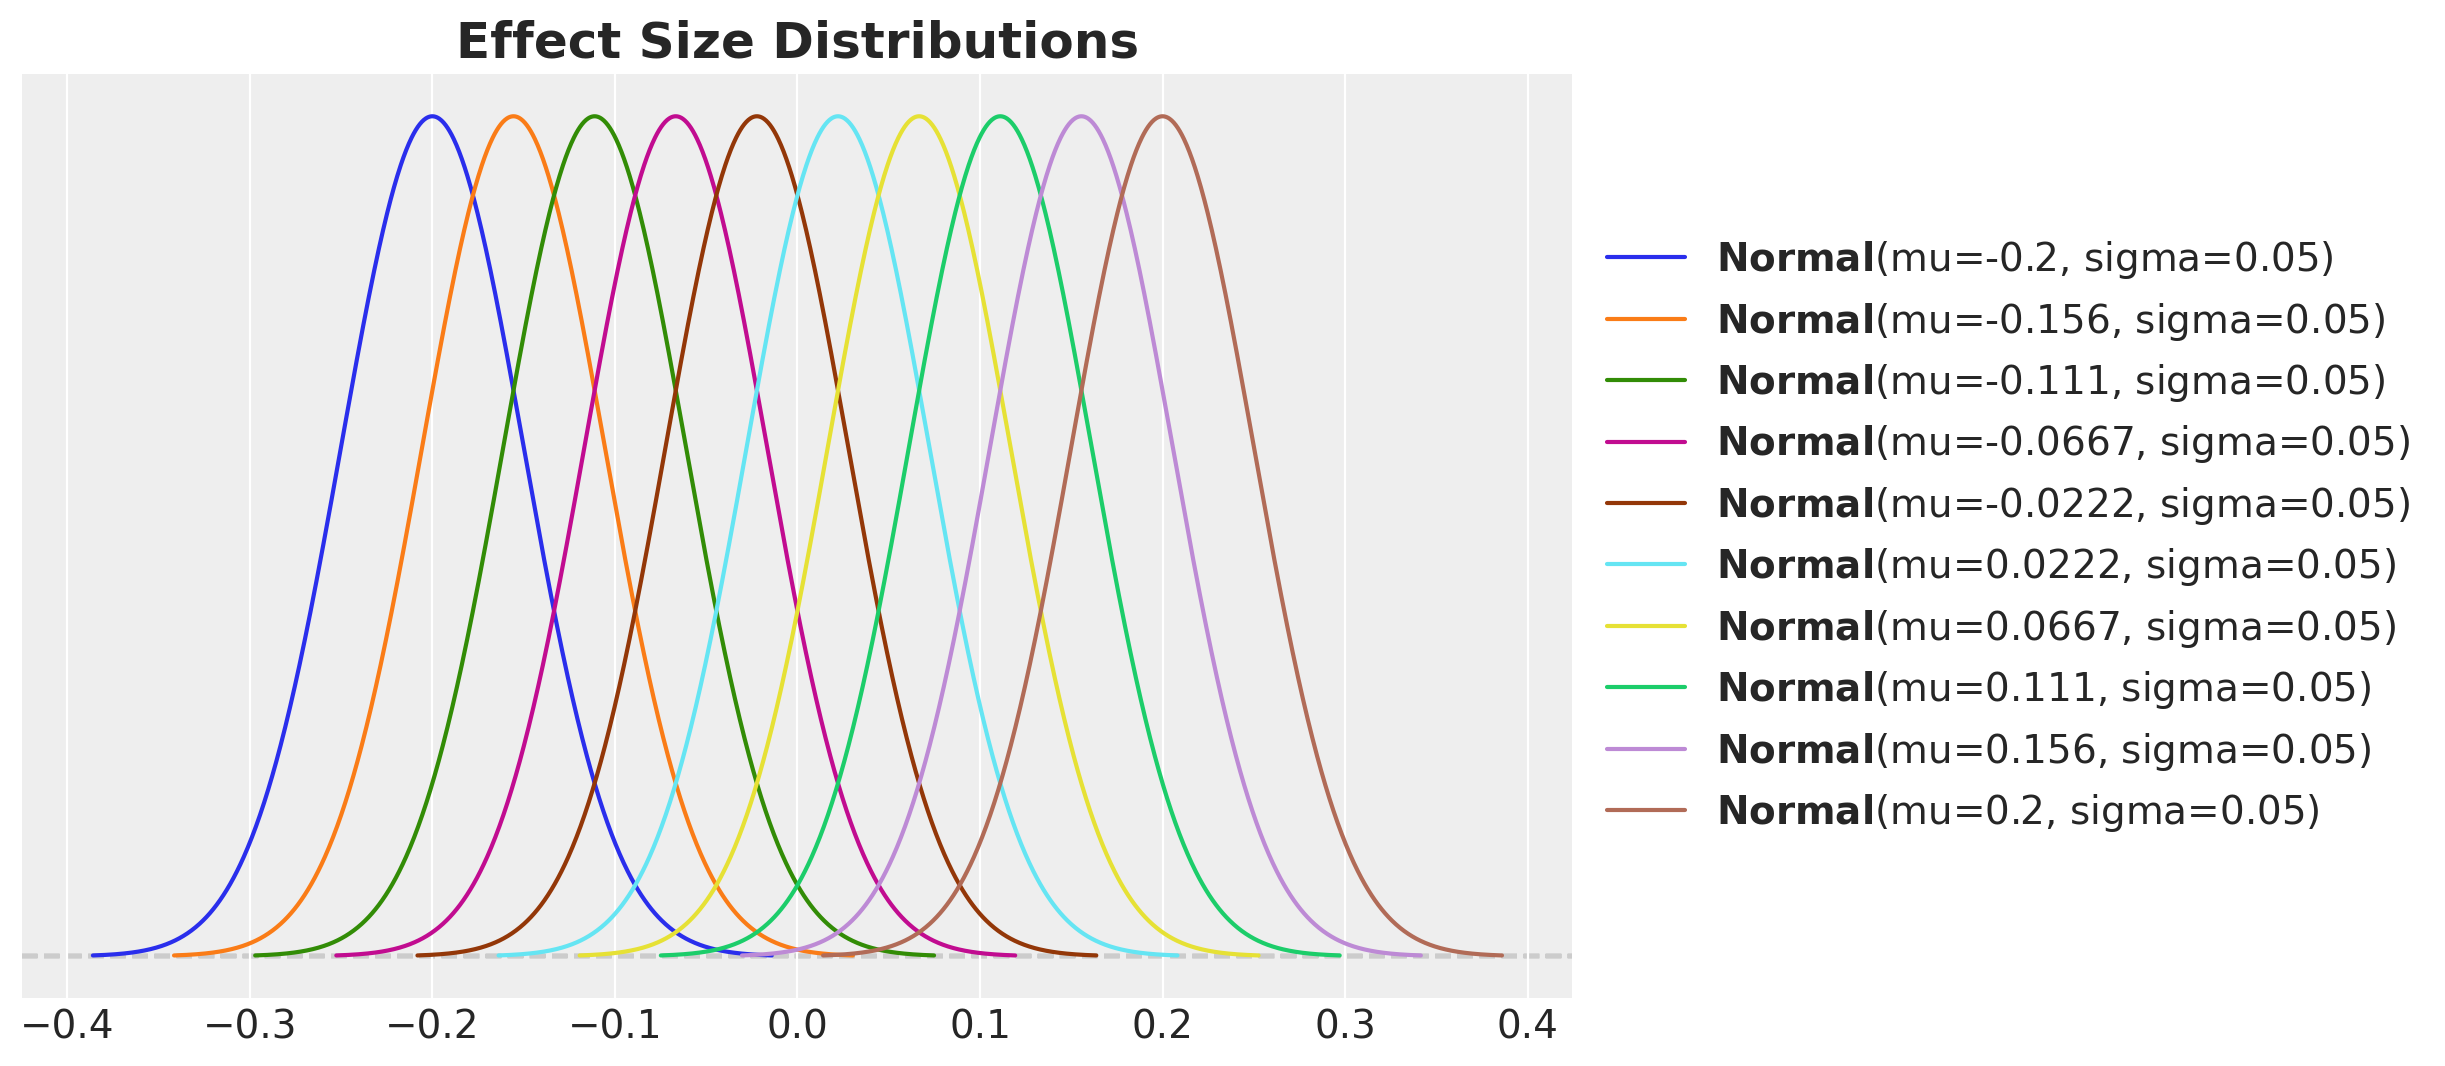

In [4]:
fig, ax = plt.subplots()

for relative_lift in power_analysis_config.relative_lifts:
    pz.Normal(mu=relative_lift, sigma=0.05).plot_pdf(ax=ax)

ax.set_title("Effect Size Distributions", fontsize=18, fontweight="bold");

Sampling: [conversion_rate_control, n_control, n_treatment, relative_lift]


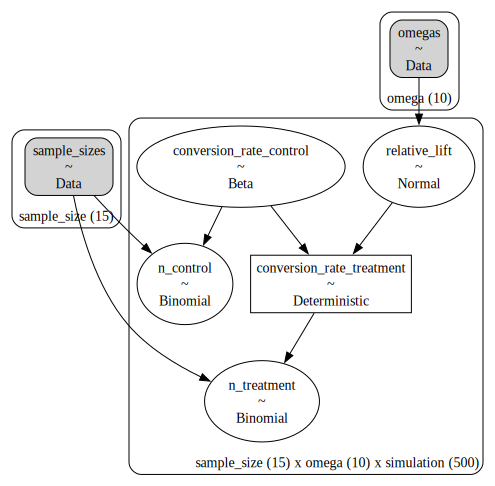

In [5]:
def generating_model_factory(
    power_analysis_config: PowerAnalysisConfig, rng: np.random.Generator
) -> tuple[az.InferenceData, pm.Model]:
    coords = {
        "sample_size": power_analysis_config.sample_sizes,
        "omega": power_analysis_config.relative_lifts,
        "simulation": range(power_analysis_config.n_simulations),
    }

    with pm.Model(coords=coords) as model:
        # Data container for the sample sizes we want to consider.
        sample_sizes_ = pm.Data(
            "sample_sizes",
            power_analysis_config.sample_sizes,
            dims=("sample_size",),
        )
        # Expand the sample sizes to the shape of the model.
        sample_sizes_expanded = pt.expand_dims(
            pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
        )
        # Data container for the omegas we want to consider.
        omegas_ = pm.Data(
            "omegas", power_analysis_config.relative_lifts, dims=("omega",)
        )
        # Expand the omegas to the shape of the model.
        omegas_expanded = pt.expand_dims(pt.as_tensor_variable(omegas_), axis=[0, 2])
        # Sample from the hypothetical distribution.
        relative_lift = pm.Normal(
            "relative_lift",
            mu=omegas_expanded,
            sigma=0.05,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_control = pm.Beta(
            "conversion_rate_control",
            alpha=15,
            beta=600,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_treatment = pm.Deterministic(
            "conversion_rate_treatment",
            conversion_rate_control * (1 + relative_lift),
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_control",
            n=sample_sizes_expanded,
            p=conversion_rate_control,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_treatment",
            n=sample_sizes_expanded,
            p=conversion_rate_treatment,
            dims=("sample_size", "omega", "simulation"),
        )

        idata = pm.sample_prior_predictive(samples=1, random_seed=rng)

    return idata, model


generating_model_idata, data_generating_model = generating_model_factory(
    power_analysis_config=power_analysis_config, rng=rng
)

pm.model_to_graphviz(data_generating_model)

In [6]:
data_control = generating_model_idata["prior"]["n_control"].sel(chain=0, draw=0)
data_treatment = generating_model_idata["prior"]["n_treatment"].sel(chain=0, draw=0)

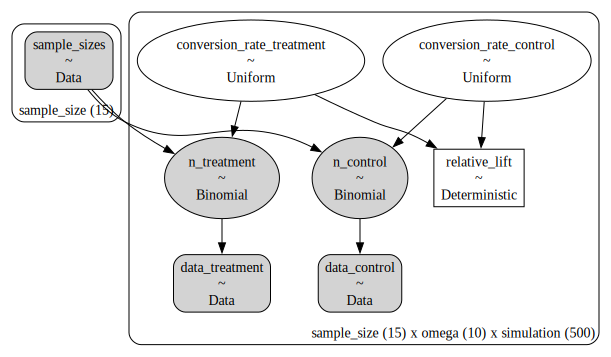

In [7]:
coords = {
    "sample_size": power_analysis_config.sample_sizes,
    "omega": power_analysis_config.relative_lifts,
    "simulation": range(power_analysis_config.n_simulations),
}

with pm.Model(coords=coords) as non_informative_model:
    sample_sizes_ = pm.Data(
        "sample_sizes",
        power_analysis_config.sample_sizes,
        dims=("sample_size",),
    )

    data_control_ = pm.Data(
        "data_control",
        data_control,
        dims=("sample_size", "omega", "simulation"),
    )

    data_treatment_ = pm.Data(
        "data_treatment",
        data_treatment,
        dims=("sample_size", "omega", "simulation"),
    )

    # Expand the sample sizes to the shape of the model.
    sample_sizes_expanded = pt.expand_dims(
        pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
    )

    conversion_rate_control = pm.Uniform(
        "conversion_rate_control",
        lower=0,
        upper=1,
        dims=("sample_size", "omega", "simulation"),
    )

    conversion_rate_treatment = pm.Uniform(
        "conversion_rate_treatment",
        lower=0,
        upper=1,
        dims=("sample_size", "omega", "simulation"),
    )

    relative_lift = pm.Deterministic(
        "relative_lift",
        conversion_rate_treatment / conversion_rate_control - 1,
        dims=("sample_size", "omega", "simulation"),
    )

    pm.Binomial(
        "n_control",
        n=sample_sizes_expanded,
        p=conversion_rate_control,
        observed=data_control_,
        dims=("sample_size", "omega", "simulation"),
    )

    pm.Binomial(
        "n_treatment",
        n=sample_sizes_expanded,
        p=conversion_rate_treatment,
        observed=data_treatment_,
        dims=("sample_size", "omega", "simulation"),
    )


pm.model_to_graphviz(non_informative_model)

In [ ]:
%%time

with non_informative_model:
    idata = pm.sample(
        draws=200,
        chains=10,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x15c0227a0>
Traceback (most recent call last):
  File "/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.12/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


Progress,Draws,Divergences,Step Size,Gradients/Draw
,13,0,0.04,255
,14,0,0.07,255
,13,0,0.05,255
,18,0,0.24,63
,21,0,0.42,31
,10,0,0.03,63
,12,0,0.03,63
,13,0,0.22,63
,14,0,0.08,255
,15,0,0.15,127


In [ ]:
idata["posterior"]["relative_lift"].median(
    dim=["chain", "draw", "sample_size", "simulation"]
)

In [ ]:
hdi = az.hdi(idata["posterior"]["relative_lift"], hdi_prob=0.95)["relative_lift"]

In [ ]:
results = (
    (hdi.sel(hdi="lower") > power_analysis_config.rope[1])
    | (hdi.sel(hdi="higher") < power_analysis_config.rope[0])
).mean(dim="simulation")

In [ ]:
sns.lineplot(
    data=results.to_dataframe().reset_index(drop=False),
    x="sample_size",
    y="relative_lift",
    hue="omega",
)